导入相关包

In [80]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

加载数据，并查看数据是否有空值

In [81]:
train = pd.read_csv(r'D:\jupyter_work\kaike_jupyter\核心课程\1031\开课吧-BI核心课-第二课20201031-课后版本\随机森林代码\input\train_set.csv')
test = pd.read_csv(r'D:\jupyter_work\kaike_jupyter\核心课程\1031\开课吧-BI核心课-第二课20201031-课后版本\随机森林代码\input\test_set.csv')
print(train.info())
print(test.info())
test['y']=-1
print(test.columns)
data = pd.concat([train,test]).reset_index(drop=True)
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 18 columns):
ID           25317 non-null int64
age          25317 non-null int64
job          25317 non-null object
marital      25317 non-null object
education    25317 non-null object
default      25317 non-null object
balance      25317 non-null int64
housing      25317 non-null object
loan         25317 non-null object
contact      25317 non-null object
day          25317 non-null int64
month        25317 non-null object
duration     25317 non-null int64
campaign     25317 non-null int64
pdays        25317 non-null int64
previous     25317 non-null int64
poutcome     25317 non-null object
y            25317 non-null int64
dtypes: int64(9), object(9)
memory usage: 3.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10852 entries, 0 to 10851
Data columns (total 17 columns):
ID           10852 non-null int64
age          10852 non-null int64
job          10852 non-null object
mar

In [82]:
len(data)

36169

把离散变量转换成数值

In [83]:
cat_col = [i for i in data.select_dtypes(object).columns if i not in ['ID', 'y']]
for i in tqdm_notebook(cat_col):
    lbl = LabelEncoder()
    # astype 在括号里面，转换以后变成数值了
    data[i] = lbl.fit_transform(data[i].astype(str))

In [84]:
data[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36169 entries, 0 to 36168
Data columns (total 9 columns):
job          36169 non-null int32
marital      36169 non-null int32
education    36169 non-null int32
default      36169 non-null int32
housing      36169 non-null int32
loan         36169 non-null int32
contact      36169 non-null int32
month        36169 non-null int32
poutcome     36169 non-null int32
dtypes: int32(9)
memory usage: 1.2 MB


In [85]:
feats = [i for i in data.columns if i not in ['ID', 'y']]
feats

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [86]:
train = data[data['y'] != -1]

k折交叉验证

In [87]:
from sklearn.model_selection import KFold
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=202)

def K_fold_vali(train_data, test_data, y, oof, model, res):
    for train_idx, vali_idx in kfold.split(train_data):
        train_x = train_data.loc[train_idx]
        train_y = y.loc[train_idx]
        val_x = train_data.loc[vali_idx]
        val_y = y.loc[vali_idx]
        # eval_metric 和early_stopping_rounds 参数是配对出现，不然会报错
        try:
            model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], categorical_feature=cat_col, eval_metric='logloss', early_stopping_rounds=100)
        except:
            model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)])
        oof[vali_idx] = model.predict_proba(val_x)[:, 1]
        res['pred'] += model.predict_proba(test_data)[:, 1]
    return oof, res

分离训练和测试集

In [88]:
tar = data[data['y'] != -1][feats]
y = data[data['y'] != -1]['y']
testx = data[data['y'] == -1][feats]

lgb

In [89]:
import lightgbm as lgb


clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=30, reg_alpha=0, reg_lambda=0, max_depth=10, n_estimators=1500, 
                          objective='binary', metric='auc', subsample=0.95, colsample_bytree=0.8, subsample_freq=1, learning_rate=0.05,
                         random_state=2020)

res = data[data['y'] == -1][['ID']]
res['pred'] = 0
oof = np.zeros(len(tar),)

oof_1, res_1 = K_fold_vali(tar, testx, y, oof, clf, res)
print('lgb AUC：', roc_auc_score(y, oof_1))
res_1['pred'] = res_1['pred'] / n_splits
res.to_csv('submission5_lgb.csv', index=False)

[1]	training's binary_logloss: 0.343928	training's auc: 0.886541	valid_1's binary_logloss: 0.349058	valid_1's auc: 0.875586
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.329992	training's auc: 0.918861	valid_1's binary_logloss: 0.33569	valid_1's auc: 0.910917
[3]	training's binary_logloss: 0.322339	training's auc: 0.929249	valid_1's binary_logloss: 0.329026	valid_1's auc: 0.920162
[4]	training's binary_logloss: 0.311489	training's auc: 0.929705	valid_1's binary_logloss: 0.318284	valid_1's auc: 0.921227
[5]	training's binary_logloss: 0.302103	training's auc: 0.930274	valid_1's binary_logloss: 0.309106	valid_1's auc: 0.923116
[6]	training's binary_logloss: 0.293704	training's auc: 0.932461	valid_1's binary_logloss: 0.300743	valid_1's auc: 0.926298
[7]	training's binary_logloss: 0.286466	training's auc: 0.932696	valid_1's binary_logloss: 0.293549	valid_1's auc: 0.926143
[8]	training's binary_logloss: 0.280315	training's auc: 0.933079	valid_

[131]	training's binary_logloss: 0.15613	training's auc: 0.965883	valid_1's binary_logloss: 0.195967	valid_1's auc: 0.937726
[132]	training's binary_logloss: 0.1558	training's auc: 0.966073	valid_1's binary_logloss: 0.195768	valid_1's auc: 0.937907
[133]	training's binary_logloss: 0.155498	training's auc: 0.96619	valid_1's binary_logloss: 0.19576	valid_1's auc: 0.937882
[134]	training's binary_logloss: 0.155193	training's auc: 0.966343	valid_1's binary_logloss: 0.195707	valid_1's auc: 0.937897
[135]	training's binary_logloss: 0.154927	training's auc: 0.966492	valid_1's binary_logloss: 0.19562	valid_1's auc: 0.93794
[136]	training's binary_logloss: 0.154651	training's auc: 0.966685	valid_1's binary_logloss: 0.19559	valid_1's auc: 0.93796
[137]	training's binary_logloss: 0.154429	training's auc: 0.966808	valid_1's binary_logloss: 0.195537	valid_1's auc: 0.938007
[138]	training's binary_logloss: 0.154183	training's auc: 0.96694	valid_1's binary_logloss: 0.195502	valid_1's auc: 0.937986
[1

[12]	training's binary_logloss: 0.257693	training's auc: 0.934178	valid_1's binary_logloss: 0.271205	valid_1's auc: 0.928418
[13]	training's binary_logloss: 0.253894	training's auc: 0.934478	valid_1's binary_logloss: 0.267631	valid_1's auc: 0.928091
[14]	training's binary_logloss: 0.251246	training's auc: 0.936512	valid_1's binary_logloss: 0.264972	valid_1's auc: 0.92987
[15]	training's binary_logloss: 0.247411	training's auc: 0.937005	valid_1's binary_logloss: 0.261215	valid_1's auc: 0.929891
[16]	training's binary_logloss: 0.244983	training's auc: 0.93826	valid_1's binary_logloss: 0.258718	valid_1's auc: 0.931303
[17]	training's binary_logloss: 0.241621	training's auc: 0.938518	valid_1's binary_logloss: 0.255481	valid_1's auc: 0.931269
[18]	training's binary_logloss: 0.238324	training's auc: 0.93875	valid_1's binary_logloss: 0.252151	valid_1's auc: 0.931437
[19]	training's binary_logloss: 0.235242	training's auc: 0.93889	valid_1's binary_logloss: 0.249248	valid_1's auc: 0.931169
[20]

[142]	training's binary_logloss: 0.15318	training's auc: 0.967267	valid_1's binary_logloss: 0.195801	valid_1's auc: 0.939976
[143]	training's binary_logloss: 0.152914	training's auc: 0.967415	valid_1's binary_logloss: 0.195794	valid_1's auc: 0.939963
[144]	training's binary_logloss: 0.152669	training's auc: 0.967567	valid_1's binary_logloss: 0.195777	valid_1's auc: 0.939921
[145]	training's binary_logloss: 0.152408	training's auc: 0.967739	valid_1's binary_logloss: 0.195733	valid_1's auc: 0.939964
[146]	training's binary_logloss: 0.152117	training's auc: 0.967904	valid_1's binary_logloss: 0.195643	valid_1's auc: 0.940015
[147]	training's binary_logloss: 0.151912	training's auc: 0.96801	valid_1's binary_logloss: 0.195729	valid_1's auc: 0.939978
[148]	training's binary_logloss: 0.151676	training's auc: 0.968153	valid_1's binary_logloss: 0.195788	valid_1's auc: 0.939953
[149]	training's binary_logloss: 0.1514	training's auc: 0.968298	valid_1's binary_logloss: 0.195773	valid_1's auc: 0.939

[44]	training's binary_logloss: 0.197272	training's auc: 0.948262	valid_1's binary_logloss: 0.211203	valid_1's auc: 0.930638
[45]	training's binary_logloss: 0.19669	training's auc: 0.948543	valid_1's binary_logloss: 0.211008	valid_1's auc: 0.93059
[46]	training's binary_logloss: 0.195683	training's auc: 0.948798	valid_1's binary_logloss: 0.210312	valid_1's auc: 0.930739
[47]	training's binary_logloss: 0.194801	training's auc: 0.94897	valid_1's binary_logloss: 0.209842	valid_1's auc: 0.930765
[48]	training's binary_logloss: 0.193684	training's auc: 0.949286	valid_1's binary_logloss: 0.20886	valid_1's auc: 0.9313
[49]	training's binary_logloss: 0.192807	training's auc: 0.949433	valid_1's binary_logloss: 0.20837	valid_1's auc: 0.931399
[50]	training's binary_logloss: 0.191959	training's auc: 0.949545	valid_1's binary_logloss: 0.207986	valid_1's auc: 0.931341
[51]	training's binary_logloss: 0.191086	training's auc: 0.949696	valid_1's binary_logloss: 0.207483	valid_1's auc: 0.931287
[52]	tr

[5]	training's binary_logloss: 0.303436	training's auc: 0.931468	valid_1's binary_logloss: 0.305298	valid_1's auc: 0.915391
[6]	training's binary_logloss: 0.294763	training's auc: 0.933538	valid_1's binary_logloss: 0.297807	valid_1's auc: 0.917409
[7]	training's binary_logloss: 0.287179	training's auc: 0.933499	valid_1's binary_logloss: 0.291149	valid_1's auc: 0.917362
[8]	training's binary_logloss: 0.280889	training's auc: 0.93418	valid_1's binary_logloss: 0.285859	valid_1's auc: 0.917976
[9]	training's binary_logloss: 0.274349	training's auc: 0.934887	valid_1's binary_logloss: 0.279956	valid_1's auc: 0.919265
[10]	training's binary_logloss: 0.269318	training's auc: 0.935122	valid_1's binary_logloss: 0.275664	valid_1's auc: 0.918925
[11]	training's binary_logloss: 0.264093	training's auc: 0.935706	valid_1's binary_logloss: 0.270901	valid_1's auc: 0.919184
[12]	training's binary_logloss: 0.25918	training's auc: 0.936056	valid_1's binary_logloss: 0.266523	valid_1's auc: 0.919242
[13]	tr

[135]	training's binary_logloss: 0.153574	training's auc: 0.967462	valid_1's binary_logloss: 0.203673	valid_1's auc: 0.928918
[136]	training's binary_logloss: 0.153334	training's auc: 0.967593	valid_1's binary_logloss: 0.203669	valid_1's auc: 0.928925
[137]	training's binary_logloss: 0.153081	training's auc: 0.967709	valid_1's binary_logloss: 0.203726	valid_1's auc: 0.928912
[138]	training's binary_logloss: 0.152847	training's auc: 0.967797	valid_1's binary_logloss: 0.203734	valid_1's auc: 0.928948
[139]	training's binary_logloss: 0.152602	training's auc: 0.967951	valid_1's binary_logloss: 0.203808	valid_1's auc: 0.9289
[140]	training's binary_logloss: 0.152345	training's auc: 0.968086	valid_1's binary_logloss: 0.203847	valid_1's auc: 0.928813
[141]	training's binary_logloss: 0.152121	training's auc: 0.968236	valid_1's binary_logloss: 0.203814	valid_1's auc: 0.928843
[142]	training's binary_logloss: 0.151917	training's auc: 0.968373	valid_1's binary_logloss: 0.203879	valid_1's auc: 0.9

[27]	training's binary_logloss: 0.222069	training's auc: 0.940467	valid_1's binary_logloss: 0.221967	valid_1's auc: 0.935781
[28]	training's binary_logloss: 0.220769	training's auc: 0.941891	valid_1's binary_logloss: 0.220956	valid_1's auc: 0.936197
[29]	training's binary_logloss: 0.218801	training's auc: 0.942114	valid_1's binary_logloss: 0.21914	valid_1's auc: 0.936513
[30]	training's binary_logloss: 0.217081	training's auc: 0.942246	valid_1's binary_logloss: 0.217719	valid_1's auc: 0.936307
[31]	training's binary_logloss: 0.215547	training's auc: 0.942379	valid_1's binary_logloss: 0.216343	valid_1's auc: 0.936534
[32]	training's binary_logloss: 0.214504	training's auc: 0.942887	valid_1's binary_logloss: 0.215427	valid_1's auc: 0.937116
[33]	training's binary_logloss: 0.213265	training's auc: 0.943669	valid_1's binary_logloss: 0.214325	valid_1's auc: 0.937728
[34]	training's binary_logloss: 0.212567	training's auc: 0.944068	valid_1's binary_logloss: 0.213936	valid_1's auc: 0.93775
[3

[157]	training's binary_logloss: 0.151817	training's auc: 0.968762	valid_1's binary_logloss: 0.183176	valid_1's auc: 0.943779
[158]	training's binary_logloss: 0.151558	training's auc: 0.968911	valid_1's binary_logloss: 0.18314	valid_1's auc: 0.94379
[159]	training's binary_logloss: 0.151277	training's auc: 0.969069	valid_1's binary_logloss: 0.183235	valid_1's auc: 0.943725
[160]	training's binary_logloss: 0.151058	training's auc: 0.969203	valid_1's binary_logloss: 0.183149	valid_1's auc: 0.943784
[161]	training's binary_logloss: 0.150788	training's auc: 0.969367	valid_1's binary_logloss: 0.183156	valid_1's auc: 0.943751
[162]	training's binary_logloss: 0.150516	training's auc: 0.9695	valid_1's binary_logloss: 0.183116	valid_1's auc: 0.943746
[163]	training's binary_logloss: 0.150293	training's auc: 0.969653	valid_1's binary_logloss: 0.183063	valid_1's auc: 0.943746
[164]	training's binary_logloss: 0.150078	training's auc: 0.969794	valid_1's binary_logloss: 0.18301	valid_1's auc: 0.9438

[287]	training's binary_logloss: 0.125683	training's auc: 0.982286	valid_1's binary_logloss: 0.181317	valid_1's auc: 0.944578
[288]	training's binary_logloss: 0.125536	training's auc: 0.982358	valid_1's binary_logloss: 0.181344	valid_1's auc: 0.944541
[289]	training's binary_logloss: 0.125369	training's auc: 0.982434	valid_1's binary_logloss: 0.181356	valid_1's auc: 0.944526
[290]	training's binary_logloss: 0.125225	training's auc: 0.982496	valid_1's binary_logloss: 0.18141	valid_1's auc: 0.944469
[291]	training's binary_logloss: 0.125023	training's auc: 0.982568	valid_1's binary_logloss: 0.181369	valid_1's auc: 0.944496
[292]	training's binary_logloss: 0.124877	training's auc: 0.982627	valid_1's binary_logloss: 0.181467	valid_1's auc: 0.944429
[293]	training's binary_logloss: 0.124682	training's auc: 0.982705	valid_1's binary_logloss: 0.181417	valid_1's auc: 0.944465
[294]	training's binary_logloss: 0.124551	training's auc: 0.982764	valid_1's binary_logloss: 0.181405	valid_1's auc: 0.

catbosst

In [90]:
from catboost import CatBoostClassifier

In [91]:
cat_params = {
    'loss_function':'Logloss',
    'custom_loss':['AUC'],
    'logging_level':'Silent',
    'task_type':'CPU',
    'early_stopping_rounds':100,
    'iterations':3000,
    'learning_rate':0.03,
    'depth':6,
    'l2_leaf_reg':3.0,
    'border_count':254
}

cat_model = CatBoostClassifier(**cat_params)
res = data[data['y'] == -1][['ID']]
res['pred'] = 0
oof = np.zeros(len(tar),)
oof_2, res_2 = K_fold_vali(tar, testx, y, oof, cat_model, res)

print('catb AUC:', roc_auc_score(y, oof_2))
res_2['pred'] = res_2['pred'] / n_splits
res.to_csv('submission5_catb.csv', index=False)

catb AUC: 0.933990900614169


xgBoost

In [92]:
from xgboost import XGBClassifier
model = XGBClassifier(
        learning_rate=0.03,#学习率
        n_estimators=3000,#步长
        max_depth=4,#深度
        objective='binary:logistic',
        seed=27,
        tree_mothod='gpu_hist',
        subsample=0.9,
        n_jobs=-1
    )
res = data[data['y'] == -1][['ID']]
res['pred'] = 0
oof = np.zeros(len(tar),)

oof_3, res_3 = K_fold_vali(tar, testx, y, oof, cat_model, res)

print('xgb AUC:', roc_auc_score(y, oof_3))
res_3['pred'] = res_3['pred'] / n_splits
res.to_csv('submission5_xgb.csv', index=False)

xgb AUC: 0.933990900614169


模型加权平均

In [93]:
oof = (oof_1 + oof_2 + oof_3) / 3
print('综合 AUC:', roc_auc_score(y, oof))
res['pred'] = (res_1['pred'] + res_2['pred'] + res_3['pred']) / n_splits
res.to_csv('submission5.csv', index=False)

综合 AUC: 0.9367702932903192


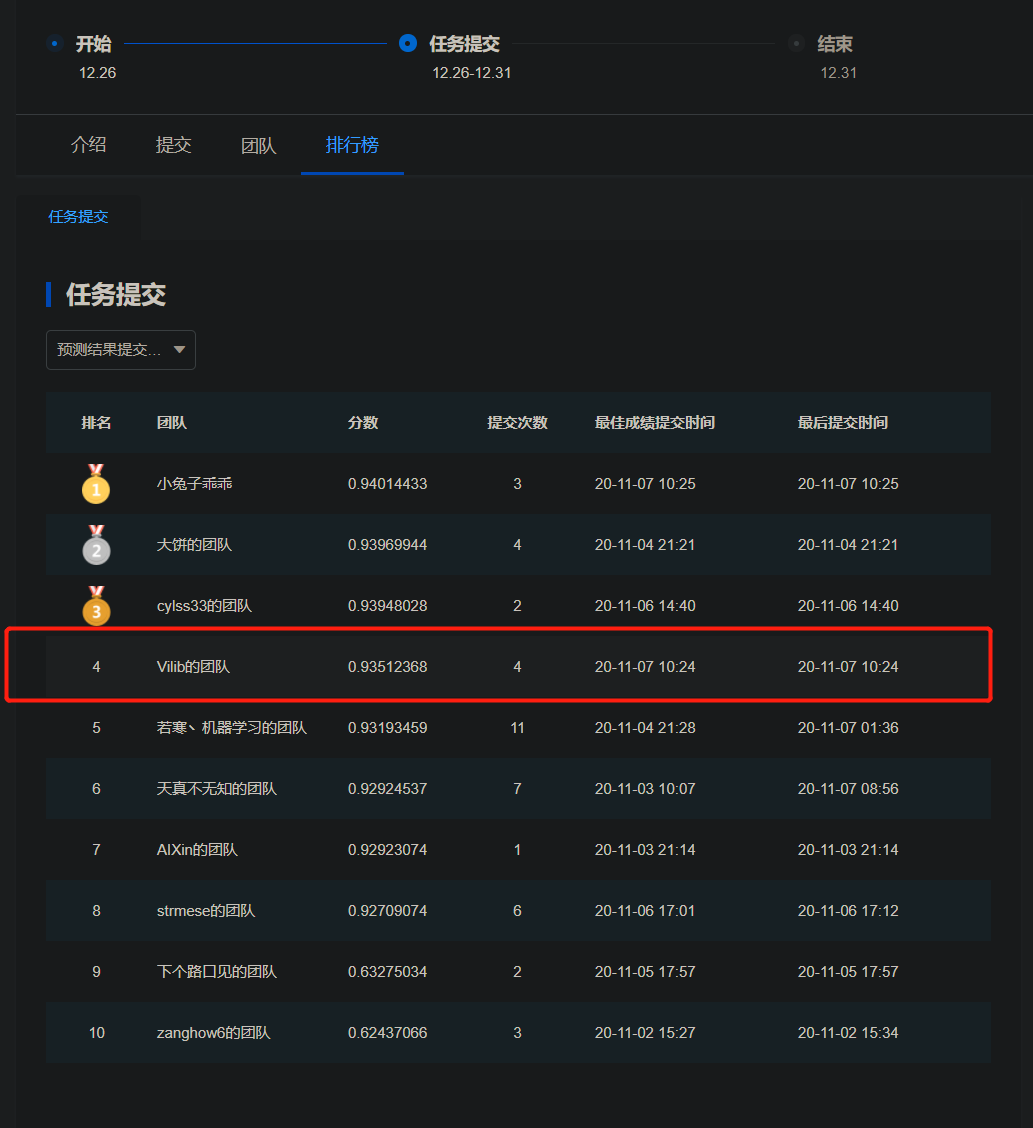